In [31]:
from SafeTransformer import SafeTransformer
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import random
import matplotlib.pyplot as plt
from copy import deepcopy

In [13]:
data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [14]:
random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
linear_model_standard = LinearRegression()
linear_model_standard = linear_model_standard.fit(X_train, y_train)
standard_predictions = linear_model_standard.predict(X_test)

mean_squared_error(y_test, standard_predictions)

22.897114784362394

In [17]:
gbm_model = GradientBoostingRegressor(n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    loss='huber')
gbm_model = gbm_model.fit(X_train, y_train)
gbm_predictions = gbm_model.predict(X_test)

mean_squared_error(y_test, gbm_predictions)

11.350385052169495

In [18]:
random.seed(123)
surrogate_model = GradientBoostingRegressor(n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    loss='huber')

In [26]:
best_score = float('Inf')
best_pen = 0
errors = []
pens = np.linspace(0.01, 10, 25)
surrogate_model = surrogate_model.fit(X_train, y_train)
for pen in pens:
    safe_transformer = SafeTransformer(surrogate_model, penalty = pen)

    safe_transformer = safe_transformer.fit(pd.DataFrame(X_train))

    X_train_transformed = safe_transformer.transform(X_train)

    X_test_transformed = safe_transformer.transform(X_test)

    linear_model_transformed = LinearRegression()

    linear_model_transformed = linear_model_transformed.fit(X_train_transformed, y_train)

    surrogate_predictions = linear_model_transformed.predict(X_test_transformed)
    error = mean_squared_error(y_test, surrogate_predictions)
    errors.append(error)
    print([pen,error])
    if error < best_score:
        best_transformer = deepcopy(safe_transformer)
        best_model = deepcopy(linear_model_transformed)
        best_score = error
        best_pen = pen
        

[0.01, 1.4944851824739782e+23]
[0.42625, 18.101423314892802]
[0.8425, 15.908341891217114]
[1.25875, 15.147569182873244]
[1.675, 14.988270305906116]
[2.0912499999999996, 14.929171502501719]
[2.5075, 14.505030807171881]
[2.92375, 16.352444060529262]
[3.34, 15.628224906421364]
[3.7562499999999996, 15.921450042645603]
[4.172499999999999, 14.972020120362092]
[4.58875, 13.978865773127502]
[5.005, 13.978865773127502]
[5.42125, 14.412450902239446]
[5.8375, 14.412450902239446]
[6.25375, 14.16562425655144]
[6.67, 14.16562425655144]
[7.08625, 14.16562425655144]
[7.5024999999999995, 14.254184570388956]
[7.91875, 14.572038425376837]
[8.334999999999999, 14.572038425376837]
[8.75125, 14.436294355110853]
[9.1675, 14.60380041514319]
[9.58375, 14.518972004197098]
[10.0, 14.654211492011555]


In [28]:
best_score

13.978865773127502

In [29]:
gb_predictions = surrogate_model.predict(X_test)
print(mean_squared_error(y_test, gb_predictions))

10.992437505457678


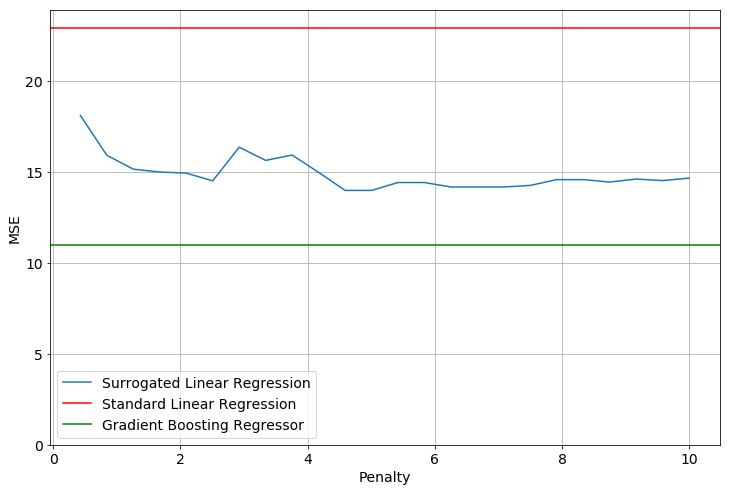

In [32]:
standard_error = mean_squared_error(y_test, standard_predictions)
xgb_error = mean_squared_error(y_test, gb_predictions)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 14})
plt.plot(pens[1:], errors[1:], label='Surrogated Linear Regression')
plt.xlabel('Penalty')
plt.ylabel('MSE')
plt.grid(True)
plt.axhline(standard_error, color='r', label='Standard Linear Regression')
plt.axhline(xgb_error, color='g', label='Gradient Boosting Regressor')
plt.ylim((0, max(max(errors[1:])+1, standard_error+1)))
plt.legend()
plt.show()